# Lab03 - Image Segmentation - Region Growing Segmentation
Full name: Đinh Anh Huy - Student ID: 18110103



In [1]:
import numpy as np 
import cv2 
import pandas as pd
import json
import os
import timeit
import random
from matplotlib import pyplot as plt 

from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, rank, sobel
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from skimage.feature import peak_local_max
from skimage.morphology import watershed, disk
from skimage import data
from skimage.util import img_as_ubyte

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt 
    import matplotlib.gridspec as gridspec
    
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    if (nCols == 1) or (nRows == 1):
      plt.figure(figsize=(20,20))
    else:
      plt.figure(figsize=(nCols*8,nRows*5))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [3]:
def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth 
    Height = DesiredHeight

    if((Width == 0) & (Height == 0)):
        return IM
    
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)

    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)

    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST) 
    return resizedIM

In [4]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path_Data = "/content/gdrive/MyDrive/University Learning/Documents/Bien Hinh va Xu Ly Anh (Image Segmentation)/Object Segmentation Data/"
checkPath = os.path.isdir(path_Data)
print("The path and file are valid or not :", checkPath)  

The path and file are valid or not : True


In [6]:
all_names = get_subfiles(path_Data)
print("Number of Images:", len(all_names))
IMG = [] 
for i in range(len(all_names)):   
    tmp = cv2.imread(path_Data + all_names[i])
    IMG.append(tmp)
    
ImageDB = IMG.copy()
NameDB = all_names

Number of Images: 28


In [7]:
NameDB

['Lung.png',
 'Iris.jpg',
 'Melanoma.jpg',
 'Retina.jpg',
 'Face.jpg',
 'Fire.jpg',
 'Mask.jpg',
 'Sign.jpg',
 'Cross.jpg',
 'Shelf.jpg',
 'Brain.jpg',
 'Tumor.png',
 'Hand.jpg',
 'Chest.jpg',
 'Bone.jpg',
 'Gesture.jpg',
 'Emotion.jpg',
 'Car.jpg',
 'Activities.jpeg',
 'Crack.jpg',
 'Code.jpg',
 'Dust.jpg',
 'Barcode.png',
 'QR.jpg',
 'Leaf.jpg',
 'Cloths.jpg',
 'Writing.png',
 'Defect.jpg']

**Useful Functions**

In [8]:
def SegmentColorImageByMask(IM, Mask):        
    Mask = Mask.astype(np.uint8)    
    result = cv2.bitwise_and(IM, IM, mask = Mask)    
    return result

def SegmentationByOtsu(image, mask):
    image_process = image.copy()
    image_mask = mask.copy()
    
    image_process[image_mask == 0] = 0
    ListPixel = image_process.ravel()
    ListPixel = ListPixel[ListPixel > 0]
    
    from skimage.filters import threshold_otsu
    otsu_thresh = threshold_otsu(ListPixel)
    
    return otsu_thresh

In [9]:
def FillHoles(Mask):
    Result = ndi.binary_fill_holes(Mask)
    return Result
    
def morphology(Mask, Size):
    from skimage.morphology import erosion, dilation, opening, closing, white_tophat
    from skimage.morphology import disk
    selem = disk(abs(Size))
    if(Size > 0):
        result = dilation(Mask, selem)
    else:
        result = erosion(Mask, selem)  
    return result


In [10]:
def ReArrangeIndex(image_index):
  AreaList = []
  for idx in range(image_index.max() + 1):
      mask = image_index == idx
      AreaList.append(mask.sum().sum())

  sort_index = np.argsort(AreaList)[::-1]
  index = 0
  image_index_rearrange = image_index * 0
  for idx in sort_index:
      image_index_rearrange[image_index == idx] = index
      index = index + 1
  return image_index_rearrange
  
def KmeansSegmentation(img, K = 3):
  if(len(img.shape) == 3):
    vectorized = img.reshape((-1,3))
  else:
    vectorized = IM.reshape(-1)

  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_label = label.reshape((img.shape[:2]))
  result_image = res.reshape((img.shape))

  return center, result_label, result_image

In [11]:
def LabelObjectByMask(image_orig, image_mask, type = "BBox", color = (0,255,0), thick = 2):
  image_input = image_orig.copy()
  image_output = image_input.copy()

  label_img = label(image_mask)
  regions = regionprops(label_img)
  bounding_boxes = []
  for props in regions:
    minr, minc, maxr, maxc = props.bbox
    left_top = (minc, minr)
    right_bottom = (maxc, maxr)
    at_row, at_col = props.centroid

    if(type == "BBox"):
      cv2.rectangle(image_output, left_top, right_bottom, color ,thick)

    bounding_boxes.append(np.array([left_top[1], right_bottom[1], left_top[0], right_bottom[0]]))

  if(type == "Boundary"):
    color = [(number / 255) for number in color]
    image_mask = morphology(image_mask, 1)
    image_output = mark_boundaries(image_output, image_mask, color = color, mode='thick')

  return image_output, np.array(bounding_boxes)

In [12]:
def crop_and_resize_image(image, bounding_boxes, scale=0, size=None):
  img_input = image.copy()
  cropped_images = []
  for box in bounding_boxes:
    img = img_input.copy()
    box = box + np.array([-scale, scale, -scale, scale])
    if box[0] < 0:
      box[0] = 0
    if box[2] < 0:
      box[2] = 0
    if box[1] > image.shape[0]:
      box[1] = image.shape[0]
    if box[3] > image.shape[1]:
      box[3] = image.shape[1]
    cropped_img = img[box[0]: box[1], box[2]: box[3]]
    if size is None:
      cropped_images.append(ResizeImage(cropped_img, (box[3]-box[2])*5, (box[1]-box[0])*5))
    else:
      cropped_images.append(ResizeImage(cropped_img, size[0], size[1]))
  return cropped_images

In [13]:
def SelectLargestRegion(Mask):
  import pandas as pd
  from skimage.measure import label, regionprops

  mask = Mask.copy()
  mask_output = mask * 0
  label_img = label(mask)
  regions = regionprops(label_img)
  max_area = 0
  ilabel = 0
  for props in regions:
    area = props.area
    if(area > max_area):
      max_area = area
      ilabel = props.label

  mask_output = mask_output + (label_img == ilabel).astype(int)
  return mask_output

In [14]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

**WaterShed Segmentation**

In [15]:
def waterShed_Segment(image_org, image_seg, denoised_radius=2, gradient_radius=5, threshold=10, max_area=0):
  image = image_seg.copy()
  # denoise image
  denoised = rank.median(image, disk(denoised_radius))

  # find continuous region (low gradient -
  # where less than threshold for this image) --> markers
  # disk(5) is used here to get a more smooth image
  markers = rank.gradient(denoised, disk(gradient_radius)) < threshold
  markers = ndi.label(markers)[0]
  # local gradient (disk(2) is used to keep edges thin)
  gradient = rank.gradient(denoised, disk(2))

  # process the watershed
  labels = watershed(gradient, markers)

  ilabel = 0
  for i in range(1,markers.max()): # 0  is background not care in range
    area = (markers == i).sum()
    if(area > max_area):
      max_area = area
      ilabel = i

  max_mask = (markers == ilabel).astype(int)
  mask_to_process = FillHoles(max_mask) - max_mask
  image_to_process = SegmentColorImageByMask(image_org, mask_to_process)

  return markers, gradient, labels, max_mask, mask_to_process, image_to_process

**Split and Merging Regions**

In [16]:
from skimage import data, io, segmentation, color
from skimage.future import graph

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

### Yêu cầu 1.
**Thực hiện lại các thao tác trong phần hướng dẫn và tìm cách hoàn thiện phần Segmentation sau :**

1. Segment tất cả vị trí lửa trong hình và sau đó trích các phần của lửa - tâm lửa và không phải tâm lửa.

Selected Image :  
Index  5 
Name  Fire.jpg


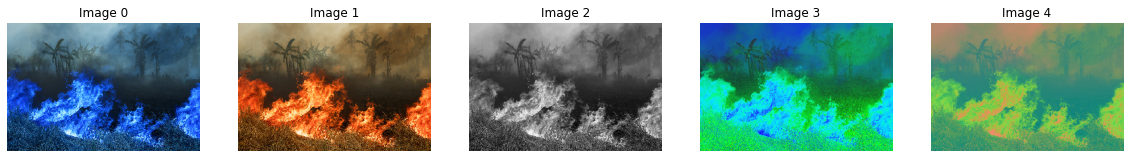

In [17]:
FileName = 'Fire.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, 300, 0)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

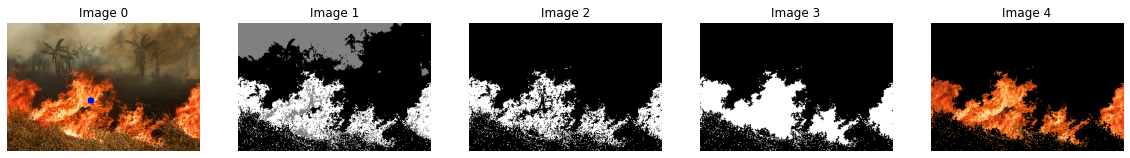

In [18]:
center, result_label, result_image = KmeansSegmentation(img, K = 3)
result_label = ReArrangeIndex(result_label)

rpoint = 120
cpoint = 130
img_select = img.copy()
cv2.circle(img_select,(cpoint,rpoint), 5, (0,0,255), -1)

idx = result_label[rpoint, cpoint]
orig_mask = result_label == idx
fill_mask = FillHoles(orig_mask)
# max_mask = SelectLargestRegion(fill_mask)
image_max_mask = SegmentColorImageByMask(img, fill_mask)

ShowImage([img_select, result_label, orig_mask, fill_mask, image_max_mask], 1, 5)

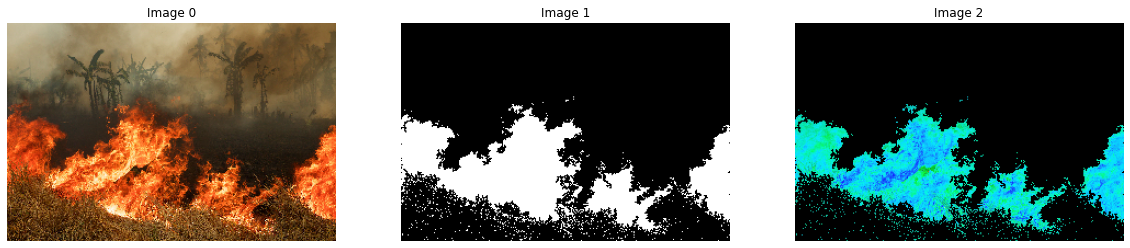

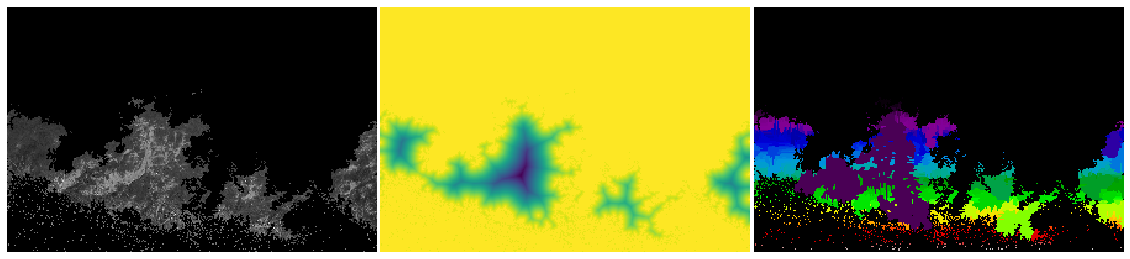

In [19]:
image_to_process = SegmentColorImageByMask(image_hsv, fill_mask)
mask_to_process = fill_mask.copy()
ShowImage([img, mask_to_process, image_to_process], 1, 3)

image = image_to_process[:,:,0].copy()
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, ax = plt.subplots(1, 3, figsize=(15.5, 3.5))
# plt.subplot(131)
ax[0].imshow(image, cmap='gray', interpolation='nearest')
ax[0].axis('off')
# plt.subplot(132)
ax[1].imshow(-distance, interpolation='nearest')
ax[1].axis('off')
# plt.subplot(133)
ax[2].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
ax[2].axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,right=1)
plt.show()

2. Đóng khung vị trí lỗi sau đó crop lỗi ra. Trên anh crop tiến hành resize cho nó bự ra và dùng watershed để phân tích các phần lõi và biên của lỗi.

Selected Image :  
Index  21 
Name  Dust.jpg


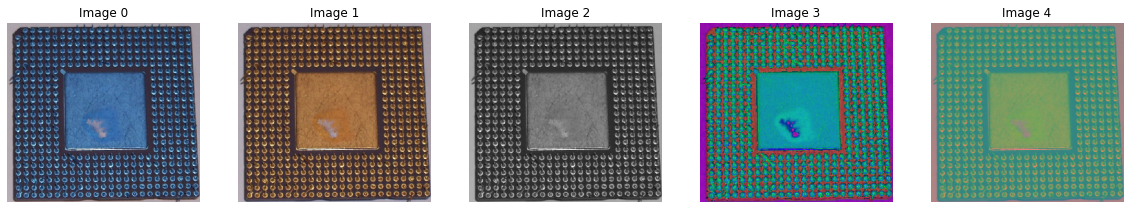

In [20]:
FileName = 'Dust.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, 300, 0)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

In [21]:
image_input = image_hsv[:,:,0]
markers, gradient, _, max_mask, mask_to_process, image_to_process = waterShed_Segment(img, image_input, denoised_radius=2, gradient_radius=3, threshold=6)

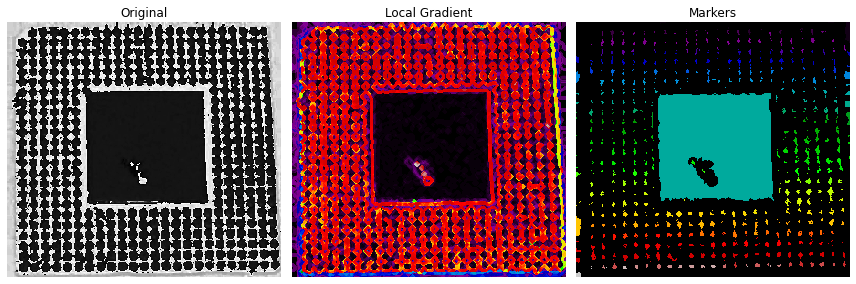

In [22]:
# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_input, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("Markers")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

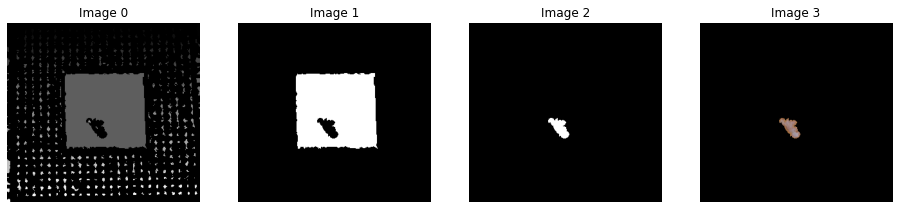

In [23]:
ShowImage([markers, max_mask, mask_to_process, image_to_process], 1, 5)

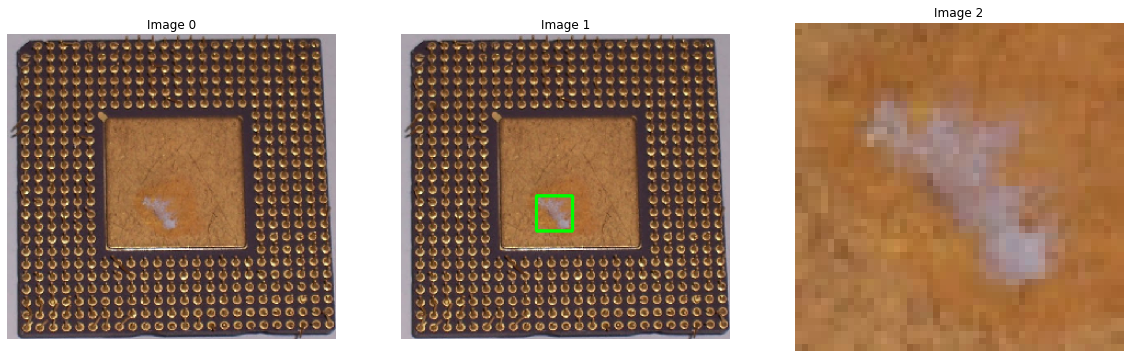

In [24]:
image_output2, bounding_boxes = LabelObjectByMask(img, mask_to_process, type = "BBox", color = (0,255,0), thick = 2)
cropped_images = crop_and_resize_image(img, bounding_boxes, scale=10, size=(50,50))
cropped_img = cropped_images[0]
ShowImage([img, image_output2, cropped_img], 1, 3)

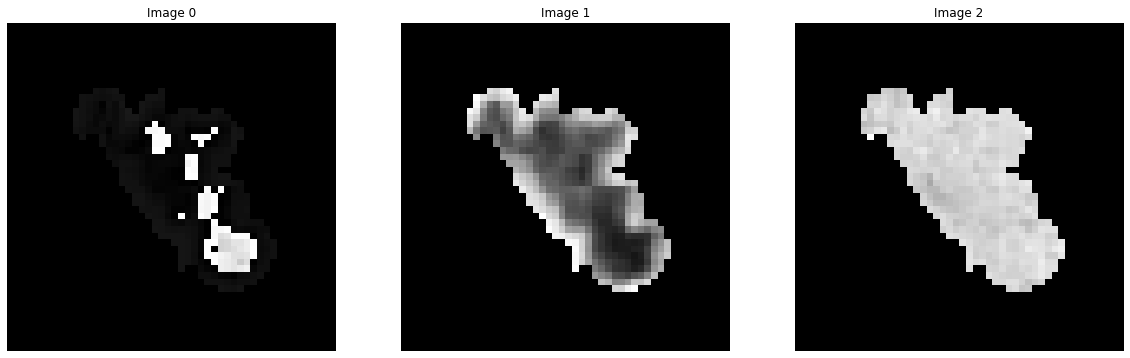

In [25]:
image_to_process = SegmentColorImageByMask(image_hsv, mask_to_process)
cropped_images1 = crop_and_resize_image(image_to_process, bounding_boxes, scale=10, size=(50,50))
cropped_img1 = cropped_images1[0]
ShowImage([cropped_img1[:,:,0], cropped_img1[:,:,1], cropped_img1[:,:,2]], 1, 3)

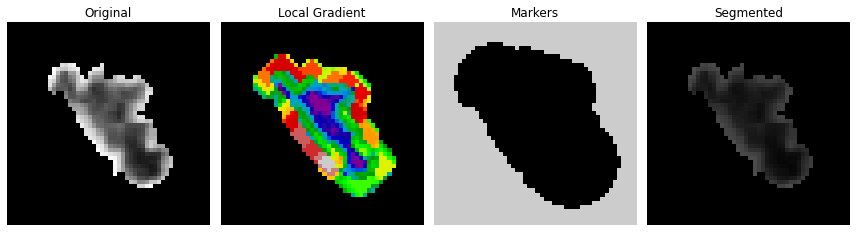

In [26]:
image_input1 = cropped_img1[:,:,1]
markers1, gradient1, labels1, max_mask1, mask_to_process1, image_to_process1 = waterShed_Segment(cropped_img1, image_input1, denoised_radius=2, gradient_radius=5, threshold=10)
# display results
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_input1, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient1, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers1, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("Markers")

ax[3].imshow(image_input1, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels1, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

3. Đóng khung vị trí lỗi sau đó crop lỗi ra. Trên anh crop tiến hành resize cho nó bự ra và dùng watershed để trích riêng từng chai nước Dr Thanh màu đỏ.

Selected Image :  
Index  9 
Name  Shelf.jpg


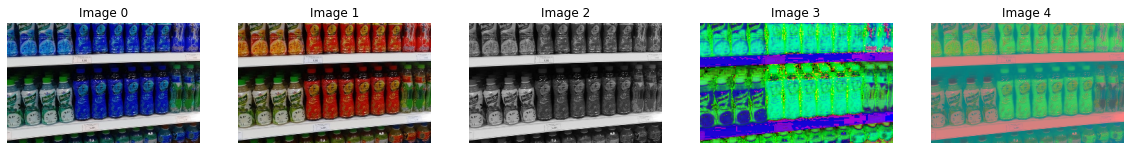

In [27]:
FileName = 'Shelf.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_orig = adjust_gamma(image_orig, gamma=1)
image_orig = ResizeImage(image_orig, 300, 0)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

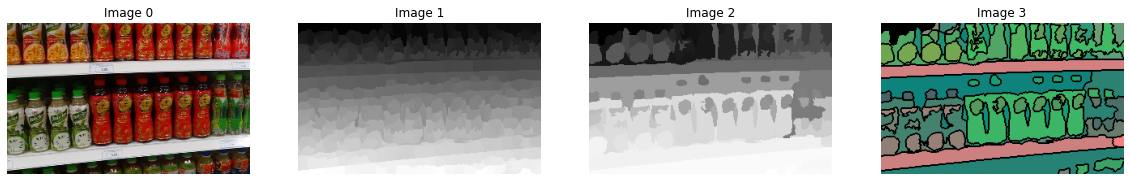

In [28]:
orig_labels = segmentation.slic(image_ycbcr, compactness=20, n_segments=400) # Slic based on Kmeans
g = graph.rag_mean_color(image_ycbcr, orig_labels)

merge_labels = graph.merge_hierarchical(orig_labels, g, thresh=30, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

image_merge_labels = color.label2rgb(merge_labels, image_ycbcr, kind='avg', bg_label=0)
image_merge_labels = segmentation.mark_boundaries(image_merge_labels, merge_labels, (0, 0, 0))
ShowImage([img, orig_labels, merge_labels, image_merge_labels], 1, 4)

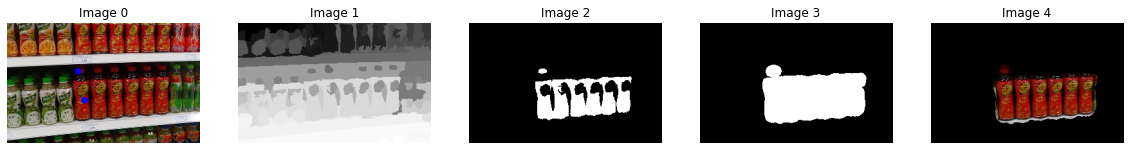

In [29]:
img_select = img.copy()
result_label = merge_labels.copy()
points = np.array([[120,120], [110, 75]])
masks = []
for point in points:
  cv2.circle(img_select,(point[0], point[1]), 5, (0,0,255), -1)

  idx = result_label[point[1], point[0]]
  masks.append(result_label == idx)

orig_mask = sum(masks)


dilation_mask = morphology(orig_mask, 6)
fill_mask = FillHoles(dilation_mask)
max_mask = SelectLargestRegion(fill_mask)
image_max_mask = SegmentColorImageByMask(img, max_mask)

ShowImage([img_select, result_label, orig_mask, fill_mask, image_max_mask], 1, 5)

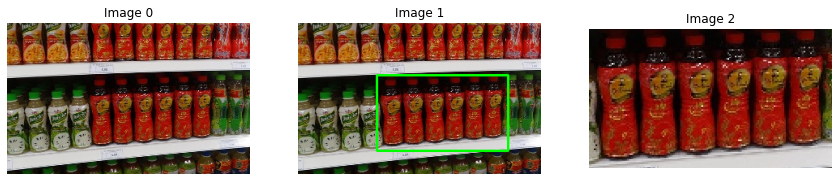

In [30]:
image_output2, bounding_boxes = LabelObjectByMask(img, max_mask, type = "BBox", color = (0,255,0), thick = 2)
cropped_images = crop_and_resize_image(img, bounding_boxes, size=(300,0))
cropped_img1 = cropped_images[0]
ShowImage([img, image_output2, cropped_img1], 1, 4)

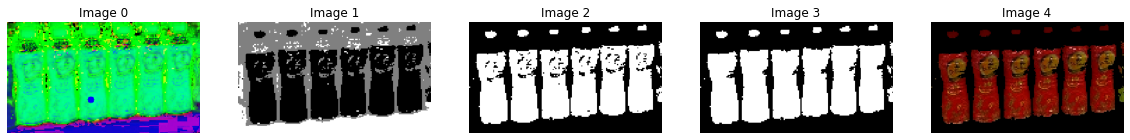

In [31]:
cropped_img2 = adjust_gamma(cropped_img1, gamma=0.8)
cropped_img1_hsv = cv2.cvtColor(cropped_img2, cv2.COLOR_RGB2HSV)

img = cropped_img1_hsv.copy()
center, result_label, result_image = KmeansSegmentation(img, K = 3)
result_label = ReArrangeIndex(result_label)

rpoint = 120
cpoint = 130
img_select = img.copy()
cv2.circle(img_select,(cpoint,rpoint), 5, (0,0,255), -1)

idx = result_label[rpoint, cpoint]
orig_mask = result_label == idx
fill_mask = FillHoles(orig_mask)
# max_mask = SelectLargestRegion(fill_mask)
image_max_mask = SegmentColorImageByMask(cropped_img2, fill_mask)

ShowImage([img_select, result_label, orig_mask, fill_mask, image_max_mask], 1, 5)

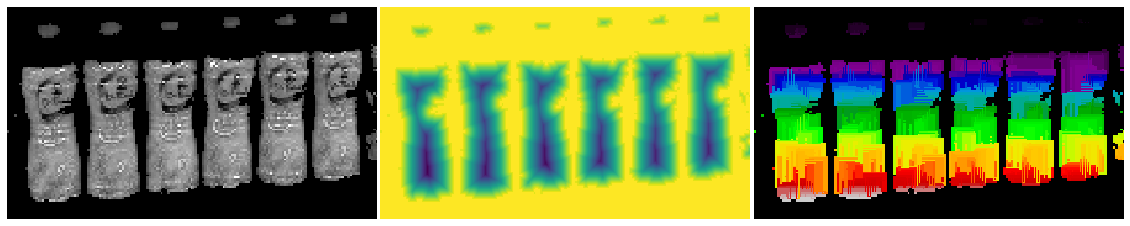

In [32]:
image = image_max_mask[:,:,0].copy()
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, ax = plt.subplots(1, 3, figsize=(15.5, 3.5))
# plt.subplot(131)
ax[0].imshow(image, cmap='gray', interpolation='nearest')
ax[0].axis('off')
# plt.subplot(132)
ax[1].imshow(-distance, interpolation='nearest')
ax[1].axis('off')
# plt.subplot(133)
ax[2].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
ax[2].axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,right=1)
plt.show()

### Yêu cầu 2.
**Chọn thêm 2 ví dụ khác trong danh sách hình và định nghĩa object cần segment trong các hình là gì và thực hiện segmentation tốt nhất bằng watershed và merging regions.**

**Ví dụ 1: Segment Leaf**

Selected Image :  
Index  24 
Name  Leaf.jpg


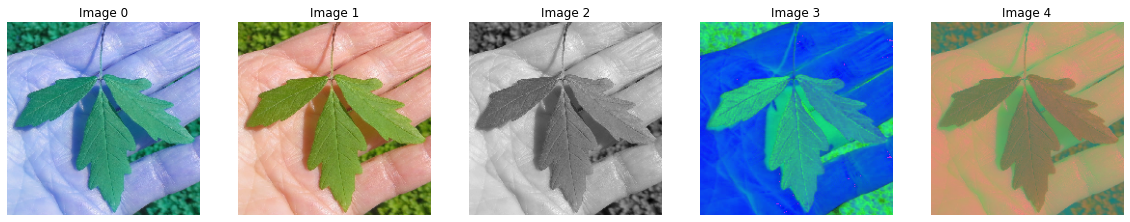

In [33]:
FileName = 'Leaf.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 200
resize_h = 200

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2YCR_CB)
ShowImage([image_orig, img, image_gray, image_hsv, image_ycbcr], 1, 5)

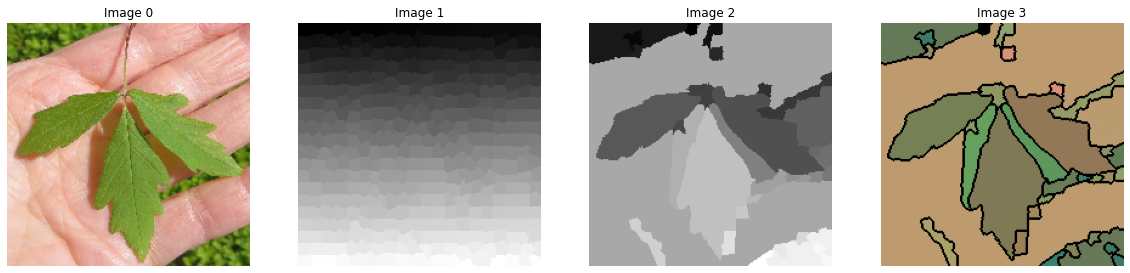

In [34]:
orig_labels = segmentation.slic(image_ycbcr, compactness=30, n_segments=400) # Slic based on Kmeans
g = graph.rag_mean_color(image_ycbcr, orig_labels)

merge_labels = graph.merge_hierarchical(orig_labels, g, thresh=23, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

image_merge_labels = color.label2rgb(merge_labels, image_ycbcr, kind='avg', bg_label=0)
image_merge_labels = segmentation.mark_boundaries(image_merge_labels, merge_labels, (0, 0, 0))
ShowImage([img, orig_labels, merge_labels, image_merge_labels], 1, 4)

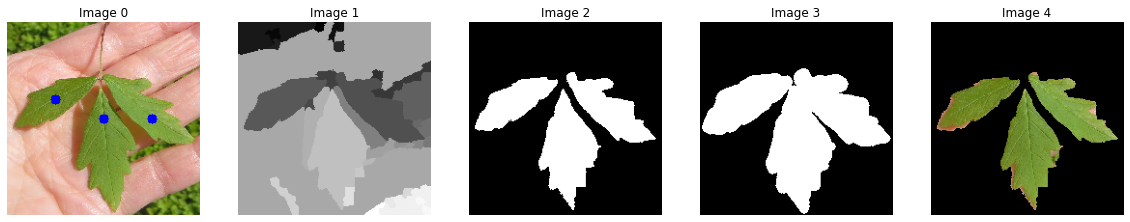

In [35]:
img_select = img.copy()
result_label = merge_labels.copy()
points = np.array([[150, 100], [100, 100], [50, 80]])
masks = []
for point in points:
  cv2.circle(img_select,(point[0], point[1]), 5, (0,0,255), -1)

  idx = result_label[point[1], point[0]]
  masks.append(result_label == idx)

orig_mask = sum(masks)


dilation_mask = morphology(orig_mask, 4)
fill_mask = FillHoles(dilation_mask)
max_mask = SelectLargestRegion(fill_mask)
image_max_mask = SegmentColorImageByMask(img, orig_mask)

ShowImage([img_select, result_label, orig_mask, fill_mask, image_max_mask], 1, 5)

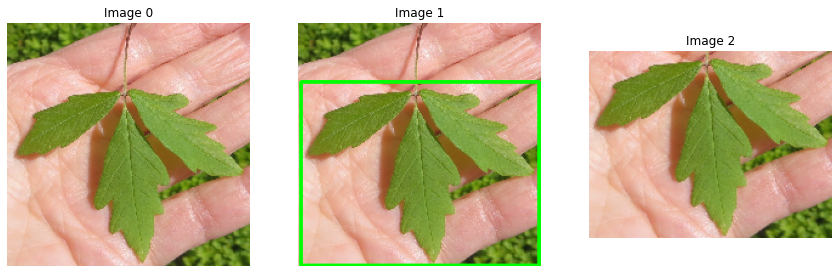

In [36]:
image_output2, bounding_boxes = LabelObjectByMask(img, max_mask, type = "BBox", color = (0,255,0), thick = 2)
cropped_images = crop_and_resize_image(img, bounding_boxes)
cropped_img1 = cropped_images[0]
ShowImage([img, image_output2, cropped_img1], 1, 4)

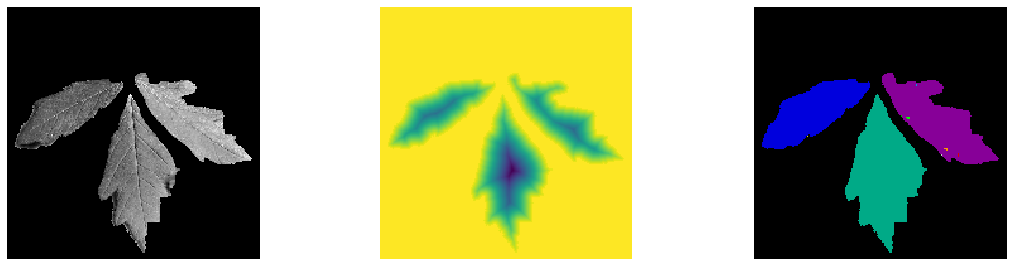

In [37]:
image = image_max_mask[:,:,1].copy()
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, ax = plt.subplots(1, 3, figsize=(15.5, 3.5))
# plt.subplot(131)
ax[0].imshow(image, cmap='gray', interpolation='nearest')
ax[0].axis('off')
# plt.subplot(132)
ax[1].imshow(-distance, interpolation='nearest')
ax[1].axis('off')
# plt.subplot(133)
ax[2].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
ax[2].axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,right=1)
plt.show()

**Ví dụ 2: Segment Gesture**

Selected Image :  
Index  15 
Name  Gesture.jpg


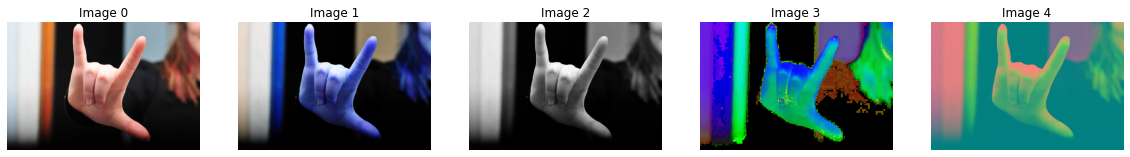

In [38]:
FileName = 'Gesture.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

resize_w = 400
resize_h = 0

image_orig = ImageDB[idx]
image_orig = ResizeImage(image_orig, resize_w, resize_h)
img = cv2.cvtColor(image_orig,cv2.COLOR_BGR2RGB)
image = adjust_gamma(image_orig, gamma=0.6)
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
ShowImage([img, image, image_gray, image_hsv, image_ycbcr], 1, 5)

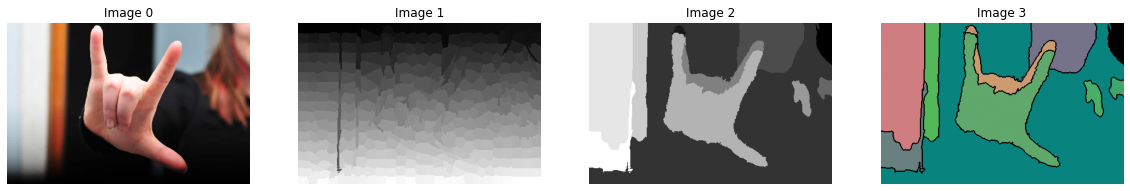

In [39]:
orig_labels = segmentation.slic(image_hsv, compactness=25, n_segments=400) # Slic based on Kmeans
g = graph.rag_mean_color(image_ycbcr, orig_labels)

merge_labels = graph.merge_hierarchical(orig_labels, g, thresh=60, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

image_merge_labels = color.label2rgb(merge_labels, image_ycbcr, kind='avg', bg_label=0)
image_merge_labels = segmentation.mark_boundaries(image_merge_labels, merge_labels, (0, 0, 0))
ShowImage([img, orig_labels, merge_labels, image_merge_labels], 1, 4)

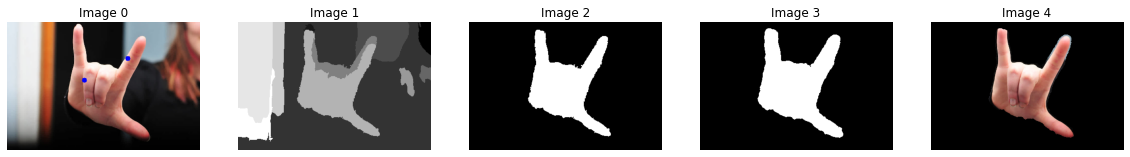

In [40]:
img_select = img.copy()
result_label = merge_labels.copy()
points = np.array([[160,120], [250, 75]])
masks = []
for point in points:
  cv2.circle(img_select,(point[0], point[1]), 5, (0,0,255), -1)

  idx = result_label[point[1], point[0]]
  masks.append(result_label == idx)

orig_mask = sum(masks)


dilation_mask = morphology(orig_mask, 3)
fill_mask = FillHoles(dilation_mask)
max_mask = SelectLargestRegion(fill_mask)
image_max_mask = SegmentColorImageByMask(img, dilation_mask)

ShowImage([img_select, result_label, orig_mask, fill_mask, image_max_mask], 1, 5)

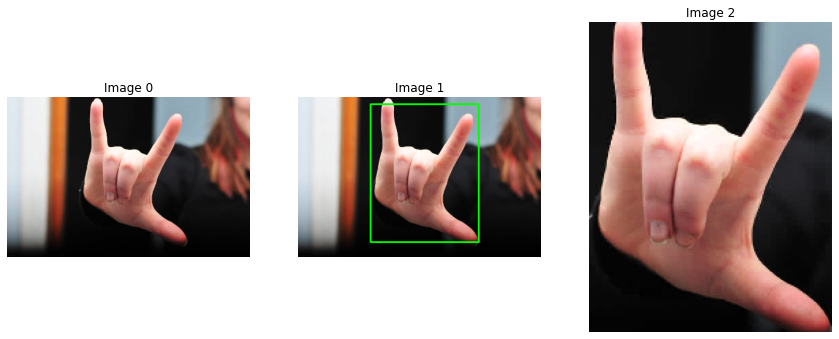

In [41]:
image_output2, bounding_boxes = LabelObjectByMask(img, max_mask, type = "BBox", color = (0,255,0), thick = 2)
cropped_images = crop_and_resize_image(img, bounding_boxes)
cropped_img1 = cropped_images[0]
ShowImage([img, image_output2, cropped_img1], 1, 4)

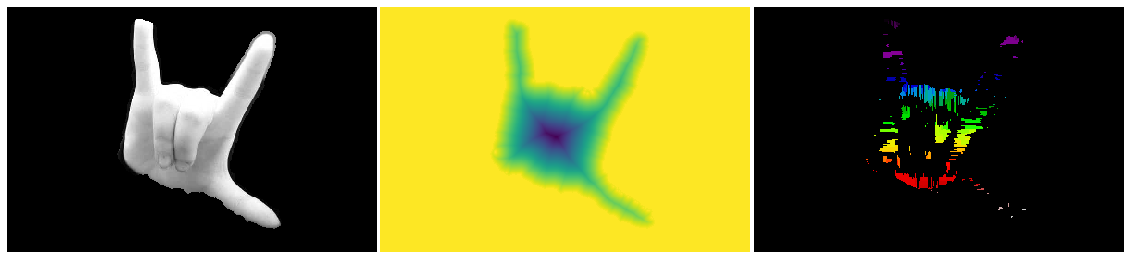

In [42]:

image = image_max_mask[:,:,0].copy()
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, ax = plt.subplots(1, 3, figsize=(15.5, 3.5))
# plt.subplot(131)
ax[0].imshow(image, cmap='gray', interpolation='nearest')
ax[0].axis('off')
# plt.subplot(132)
ax[1].imshow(-distance, interpolation='nearest')
ax[1].axis('off')
# plt.subplot(133)
ax[2].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
ax[2].axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,right=1)
plt.show()